In [1]:
from IPython.display import Markdown
from shrbk.interact import get_url, make_html_binder_button

# Provide binder badge
Markdown(make_html_binder_button(get_url('rho-statistics.ipynb')))

ModuleNotFoundError: No module named 'shrbk'

# Rho Statistics

## Introduction to Rho statistics

Rho statistics are a way to quantify the error on shear correlations due to the PSF. The first two were introduced by Rowe in 2010 ({cite}`Rowe_2010`), although they were named $D_1$ and $D_2$. In this section, we will use the same formalism as Jarvis et al. did in a paper for DES {cite}`Jarvis_2016`, with 5 rho statistics, denoted $\rho_1$ through $\rho_5$. 
When measuring the PSF, one can only get measurements at the positions of stars, and thus not directly at the positions of the galaxies for which the shape is measured. This means that the PSF must be interpolated. This interpolation will lead to correlated errors on galaxies which are close to each other. As these errors are not random, independent errors, they cannot be considered as simply an additional source of noise that can be added to the uncertainty on the shear. We expect that they will introduce a systematic error on the shear, linked to the two-point correlation functions of these errors.

Here after, we will denote the true ellipticity of the PSF (defined using the second moments) $\epsilon_\text{PSF}$, and the true size of the PSF $T_\text{PSF}$ (see the derivation for an exact definition) ; we also define $\delta \epsilon_\text{PSF}$ and $T_\text{PSF}$ the errors in ellipticity and size between the model and the true PSF.

We define the five rho statistics as :
$$\begin{align*}
\rho_1(\theta)& = <\delta \epsilon_\text{PSF}^* (x) \delta \epsilon_\text{PSF} (x+\theta)> \\
\rho_2(\theta)& = <\epsilon_\text{PSF}^* (x) \delta \epsilon_\text{PSF} (x+\theta)> \\
\rho_3(\theta)& = <\left(\epsilon_\text{PSF}^* \frac{\delta T_\text{PSF}}{T_\text{PSF}}\right) (x) \left(\epsilon_\text{PSF} \frac{\delta T_\text{PSF}}{T_\text{PSF}}\right) (x+\theta)> \\
\rho_4(\theta)& = <\delta \epsilon_\text{PSF}^* (x) \left(\epsilon_\text{PSF} \frac{\delta T_\text{PSF}}{T_\text{PSF}}\right) (x+\theta)> \\
\rho_5(\theta)& = <\epsilon_\text{PSF}^* (x) \left(\epsilon_\text{PSF} \frac{\delta T_\text{PSF}}{T_\text{PSF}}\right) (x+\theta)>
\end{align*}$$

They are computed at the location of the stars only, as we can only observe the PSF at these locations.

## Interpretation

To get a better sense of what the statistics mean and how they differ from each other, we will be making experiments using the [Piff package](https://github.com/rmjarvis/Piff), which is used for PSF modelling and allows us to easily compute the rho statistics. We will try to show how introducing an error in the model is repercuted in the rho statistics.

In [9]:
import galsim
import os
import numpy as np
import fitsio
import piff
import tempfile
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

output_dir = tempfile.mkdtemp()

def setup(sigma = 0.5,g1 = 0.02,g2 = 0,du = 0,dv = 0,flux = 123.45,stamp_size=2048,n_stars=5000,point_array=None,plot=False,randomize_ell=False):
    """Build an input image and catalog used by a few tests below.
    """
    wcs = galsim.PixelScale(0.263)
    image = galsim.Image(stamp_size, stamp_size, wcs=wcs)

    # Where to put the stars.
    if point_array is None:
        point_array = np.round(np.random.uniform(33,stamp_size-33,size=(n_stars,2)),2)
    
    x_list = point_array[:,0]
    y_list = point_array[:,1]
    
    # Draw a Gaussian PSF at each location on the image.
    for x, y in zip(x_list, y_list):
        psf = galsim.Gaussian(sigma=sigma).shear(g1=g1+randomize_ell*np.random.normal(0,0.01), g2=g2).shift(du,dv) * flux #*(stamp_size-x)/stamp_size
        image2 = galsim.Image(stamp_size, stamp_size, wcs=wcs)
        bounds = galsim.BoundsI(int(x-31), int(x+32), int(y-31), int(y+32))
        offset = galsim.PositionD(x-int(x)-0.5, y-int(y)-0.5)
        psf.drawImage(image=image2[bounds], method='no_pixel', offset=offset)
        image += image2
    image.addNoise(galsim.GaussianNoise(rng=galsim.BaseDeviate(1234), sigma=1e-6))
    if plot:
        plt.figure(figsize=(15,15))
        plt.imshow(image.array)
        plt.show()
    # Write out the image to a file
    image_file = os.path.join(output_dir,'test_stats_image.fits')
    image.write(image_file)

    # Write out the catalog to a file
    dtype = [ ('x','f8'), ('y','f8') ]
    data = np.empty(len(x_list), dtype=dtype)
    data['x'] = x_list
    data['y'] = y_list
    cat_file = os.path.join(output_dir,'test_stats_cat.fits')
    fitsio.write(cat_file, data, clobber=True)

First, we need to generate a field containing stars. Here, we will have a uniform PSF over the field so that each star is identical.

In [10]:
stamp_size = 13500
n_stars = 5000
point_array = np.round(np.random.uniform(33,stamp_size-33,size=(n_stars,2)),2)
setup(stamp_size=stamp_size,n_stars=n_stars,point_array=point_array,plot=True)

KeyboardInterrupt: 

In [73]:
logger = piff.config.setup_logger(verbose=2)
image_file = os.path.join(output_dir,'test_stats_image.fits')
cat_file = os.path.join(output_dir,'test_stats_cat.fits')
config = {
    'input' : {
        'image_file_name' : image_file,
        'cat_file_name' : cat_file,
        'stamp_size' : 30
    }
}

# Test rho statistics directly.
min_sep = 20
max_sep = 10000
bin_size = 0.5

In [84]:
def plot_single(ax, rho, color, marker, offset=0., num=1):
        # Add a single rho stat to the plot.
        meanr = rho.meanr * (1. + rho.bin_size * offset)
        xip = rho.xip
        sig = np.sqrt(rho.varxip)
        ax.plot(meanr, xip, color=color,label=r'$\rho_{}(\theta)$'.format(num))
        ax.plot(meanr, -xip, color=color, ls=':')
        ax.errorbar(meanr[xip>0], xip[xip>0], yerr=sig[xip>0], color=color, ls='', marker=marker)
        ax.errorbar(meanr[xip<0], -xip[xip<0], yerr=sig[xip<0], color=color, ls='', marker=marker,
                    fillstyle='none', mfc='white')
        
def compute_rho_stats_mean(sigma,g1,g2,du,dv,flux,plot=False):
    galsim_psf = galsim.Gaussian(sigma=sigma).shear(g1=g1, g2=g2).shift(du,dv) * flux
    model_psf = piff.GSObjectModel(galsim_psf)
    model_interp = piff.Mean()
    psf = piff.SimplePSF(model_psf,model_interp)
    orig_stars, wcs, pointing = piff.Input.process(config['input'], logger)
    stats = piff.RhoStats(min_sep=min_sep, max_sep=max_sep, bin_size=bin_size, sep_units="arcsec")
    stats.compute(psf, orig_stars)

    rhos = [stats.rho1, stats.rho2, stats.rho3, stats.rho4, stats.rho5]

    if plot:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
        ax1.set_xlabel(r'$\theta$ (arcsec)')
        ax1.set_ylabel(r'$\rho(\theta)$')
        ax1.set_xlim(min_sep,max_sep)
        ax1.set_xscale('log')
        ax1.set_yscale('log', nonposy='clip')
        ax2.set_xlabel(r'$\theta$ (arcsec)')
        ax2.set_ylabel(r'$\rho(\theta)$')
        ax2.set_xlim(min_sep,max_sep)
        ax2.set_xscale('log')
        ax2.set_yscale('log', nonposy='clip')
        plot_single(ax1,rhos[0],"red","x",num=1)
        plot_single(ax1,rhos[2],"blue","x",0.1,num=3)
        plot_single(ax1,rhos[3],"green","x",0.2,num=4)
        plot_single(ax2,rhos[1],"red","x",num=2)
        plot_single(ax2,rhos[4],"blue","x",num=5)
        ax1.legend()
        ax2.legend()
        plt.show()
        
    return [np.abs(np.mean(rho.xip)) for rho in rhos]

First, let's compute the rho statistics with a reference PSF (slightly different from the original graph so as to get a cleaner plot). To simplify, we will average the rho statistics over all scales in order to compare different situations ; since the true PSF and the model should be the same everywhere, we expect them to be approximateley constant anyway.

Reading in 1 images
Getting wcs from image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading star catalog /tmp/tmpbla4s3he/test_stats_cat.fits.
Processing catalog 0 with 5000 stars
Read a total of 5000 stars from 1 image
/home/thuiop/Documents/stageAPC/Shear-and-PSF-Reading-Group/env/lib64/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/thuiop/Documents/stageAPC/Shear-and-PSF-Reading-Group/env/lib64/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


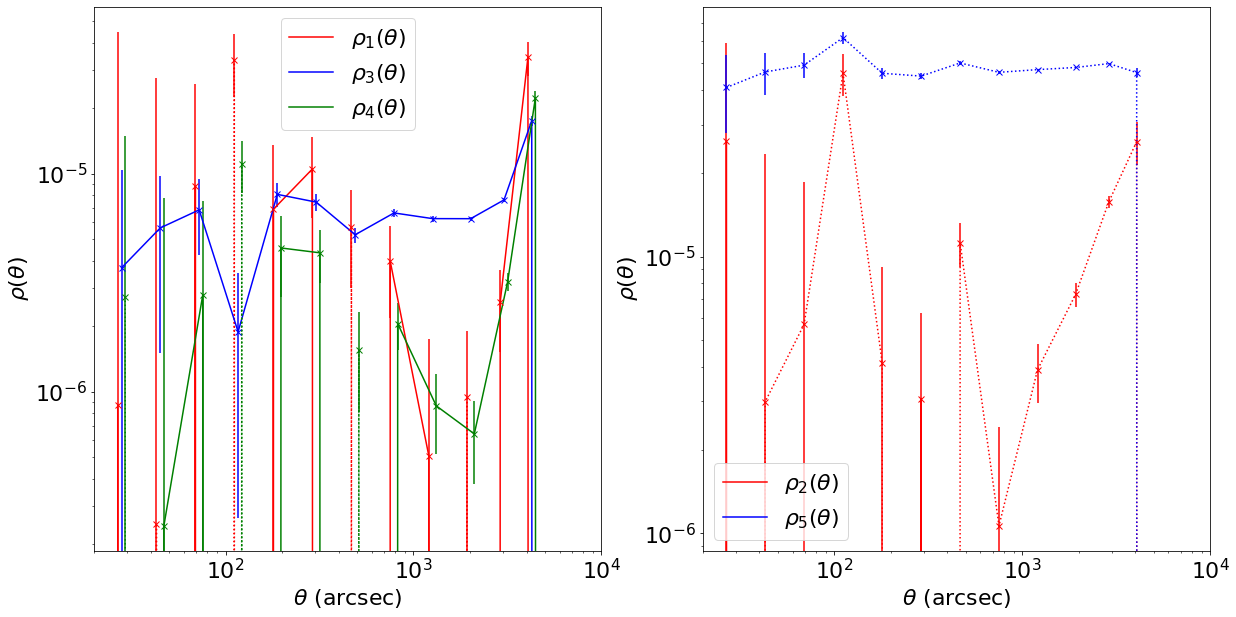

Mean rho statistics :  [2.1841270699226033e-06, 7.303996106156926e-06, 6.385208058350862e-06, 1.9693042542292676e-06, 4.445294946514094e-05]


In [85]:
sigma = 0.55
g1 = 0.02
g2 = 0
du = 0.  # in arcsec
dv = 0.
flux = 123.45
ref_rho_stats = compute_rho_stats_mean(sigma,g1,g2,du,dv,flux,plot=True)
print("Mean rho statistics : ",ref_rho_stats)

Now, let's see what happens if we give it a higher ellipticity, say by increasing the first component of the ellipticity (denoted g1 in the code). We expect that this will increase the $\delta\epsilon_\text{PSF}$ terms, while the $\epsilon_\text{PSF}$ will not change (as the real PSF stays the same) ; thus we should expect that only $\rho_1$, $\rho_2$ and $\rho_4$ will increase, and $\rho_1$ the most of all  (please note that $\delta T_\text{PSF}$ should not change by much either).

In [91]:
sigma = 0.55
g1 = 0.025
g2 = 0
du = 0.  # in arcsec
dv = 0.
flux = 123.45
high_ellipticity_rho_stats = compute_rho_stats_mean(sigma,g1,g2,du,dv,flux,plot=False)
print("Mean rho statistics : ",high_ellipticity_rho_stats)
print("Ratio compared to reference : ",[high_ellipticity_rho_stats[i]/ref_rho_stats[i] for i in range(5)])

Reading in 1 images
Getting wcs from image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading star catalog /tmp/tmpbla4s3he/test_stats_cat.fits.
Processing catalog 0 with 5000 stars
Read a total of 5000 stars from 1 image


Mean rho statistics :  [2.914068916686601e-05, 9.378189697795714e-05, 6.3856443871808e-06, 1.3575335658188338e-05, 4.445459318718626e-05]
Ratio compared to reference :  [13.342030126433366, 12.839806540819948, 1.0000683343167442, 6.893467898134084, 1.0000369766700543]


Indeed, we obtain a result that matches expectations. Let's now see the impact of changing the size of the PSF (without changing the ellipticity). This should only affect $\rho_3$, $\rho_4$ and $\rho_5$ since $\rho_1$ and $\rho_2$ do not contain the $\delta T_\text{PSF}$ factor, which evaluates the error in size (and again, $\rho_3$ should be the most impacted).

In [92]:
sigma = 0.60
g1 = 0.02
g2 = 0
du = 0.  # in arcsec
dv = 0.
flux = 123.45
high_size_rho_stats = compute_rho_stats_mean(sigma,g1,g2,du,dv,flux,plot=False)
print("Mean rho statistics : ",high_size_rho_stats)
print("Ratio compared to reference : ",[high_size_rho_stats[i]/ref_rho_stats[i] for i in range(5)])

Reading in 1 images
Getting wcs from image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading image file /tmp/tmpbla4s3he/test_stats_image.fits
Reading star catalog /tmp/tmpbla4s3he/test_stats_cat.fits.
Processing catalog 0 with 5000 stars
Read a total of 5000 stars from 1 image


Mean rho statistics :  [2.245484397987011e-06, 8.361878129901562e-06, 1.891798880627811e-05, 3.0461161251854522e-06, 7.864519945893089e-05]
Ratio compared to reference :  [1.0280923802050501, 1.1448360607493877, 2.962783457233835, 1.546798123572642, 1.769178432594282]


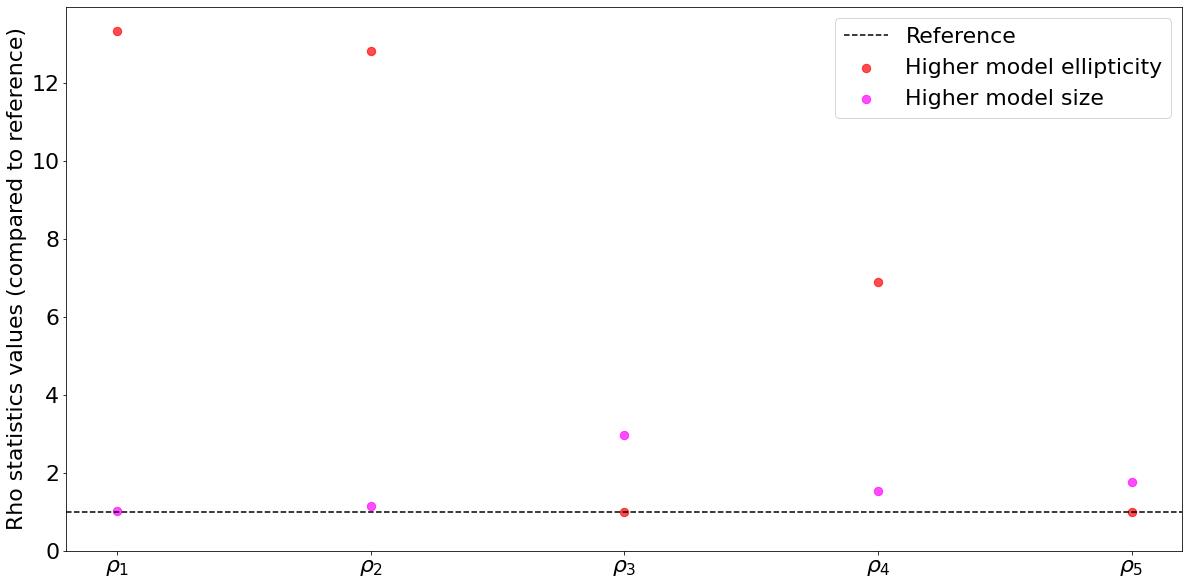

In [93]:
x = [r"$\rho_1$",r"$\rho_2$",r"$\rho_3$",r"$\rho_4$",r"$\rho_5$"]
plt.figure(figsize=(20,10))
plt.axhline(1,color="black",linestyle="--",label="Reference")
#plt.scatter(x,[1.0 for i in range(5)],marker="o",s=100,color="blue",label="Reference")
plt.scatter(x,[high_ellipticity_rho_stats[i]/ref_rho_stats[i] for i in range(5)],marker="o",s=70,color="red",label="Higher model ellipticity",alpha=0.7)
plt.scatter(x,[high_size_rho_stats[i]/ref_rho_stats[i] for i in range(5)],marker="o",s=70,color="magenta",label="Higher model size",alpha=0.7)
plt.ylabel("Rho statistics values (compared to reference)")
plt.ylim(0)
plt.legend()
plt.show()